# Testing of queue imbalance for company 9094

Order of this notebook is as follows:
1. [Data preparation](#Data-preparation)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [1](#Resources).

In [1]:
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
import lob

import warnings

warnings.filterwarnings('ignore')

## Data preparation

The data seems to be from small-tick market.

### Train data

For training data we used data from 2013-09 - 2013-10:

* 0901
* 0916
* 1001
* 1016

### Test data

For testing data we used data from first half of 2013-11

* 1101

In [2]:
df, df_test = lob.load_data('9064')
df.head()

Training set length: 20546
Testing set length: 5180


,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-02 05:01:00,"[(40.0, 12000.0), (45.0, 20000.0), (46.0, 2180...","[(74.8, 57803.0), (75.0, 13500.0), (76.0, 7660...",72.00,74.80,73.400,57803.0,25000.0,0,-0.396157
2013-09-02 07:51:00,"[(40.0, 12000.0), (42.0, 5000.0), (44.5, 20000...","[(68.2, 43640.0), (73.0, 6000.0), (74.8, 57803...",76.90,68.20,72.550,43640.0,3235.0,0,-0.861973
2013-09-02 07:53:00,"[(40.0, 12000.0), (42.0, 5000.0), (44.5, 20000...","[(65.0, 1104.0), (68.2, 43640.0), (72.91, 3534...",76.90,65.00,70.950,1104.0,8052.0,0,0.758847
2013-09-02 08:01:00,"[(40.0, 12000.0), (42.0, 5000.0), (44.5, 13906...","[(73.27, 45753.0), (73.29, 20000.0), (73.3, 26...",73.22,73.27,73.245,45753.0,1741.0,1,-0.926685
2013-09-02 08:02:00,"[(40.0, 12000.0), (42.0, 5000.0), (44.5, 13906...","[(73.35, 7000.0), (73.36, 7823.0), (73.37, 123...",73.26,73.35,73.305,7000.0,5765.0,1,-0.096749


## Data visualization

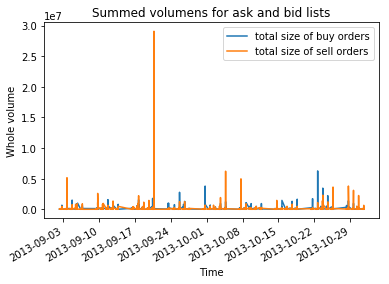

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders')
df['sum_sell_ask'].plot(label='total size of sell orders')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

Text(0,0.5,'Price')

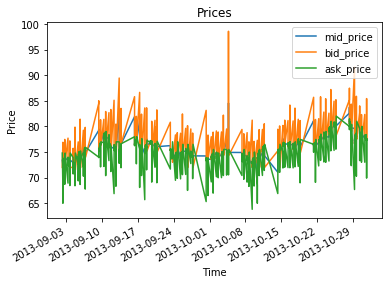

In [4]:
df[['mid_price', 'bid_price', 'ask_price']].plot()
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

Text(0.5,1,'Queue imbalance vs mid price indicator for a few records')

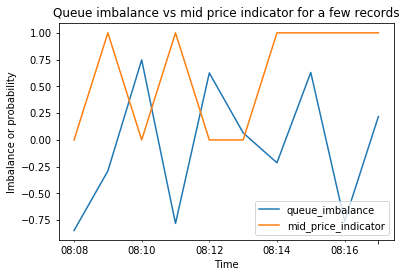

In [5]:
df.iloc[10:20][['queue_imbalance', 'mid_price_indicator']].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Imbalance or probability')
plt.title('Queue imbalance vs mid price indicator for a few records')

Text(0.5,1,'Mid price indicator density')

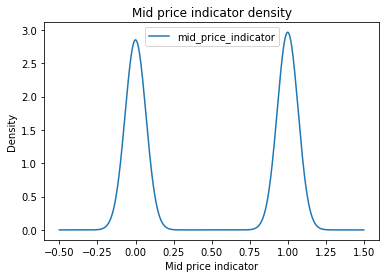

In [6]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

Text(0.5,1,'Queue imbalance density')

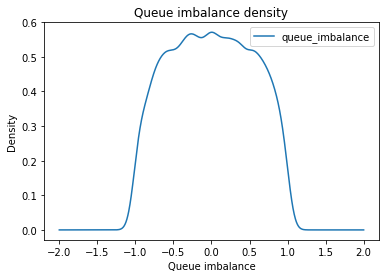

In [7]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`. Tests are performed on out-of-sample dataset.

[0.0003027600815767038, 0.24866102542245316, 0.25, 0.46196911196911195]


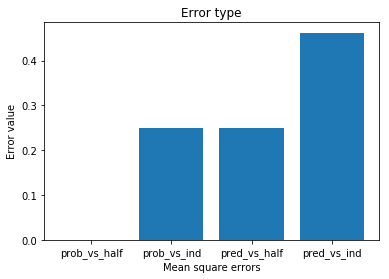

In [8]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df_test['mid_price_indicator'] - predictions) ** 2).mean()

plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')
print([prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])

Text(0,0.5,'Prediction')

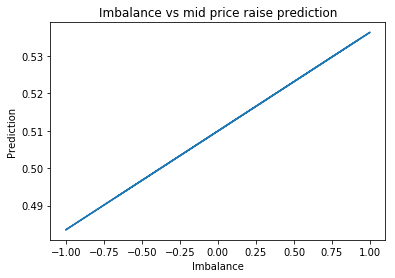

In [9]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Imbalance vs mid price raise prediction')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

Text(0,0.5,'Mid price prediction')

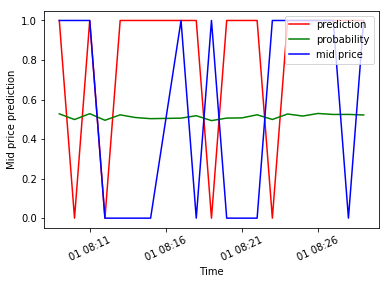

In [10]:
st = 10
end = 30

plt.plot(df_test.index[st:end], predictions[st:end], 'r', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - it looks like normal distribution: most often the queues are balanced.

Errors:

* predicted probability vs null model: 0.00030
* predicted probability vs known indicator: 0.24866
* prediction vs null model: 0.25
* prediction vs known indicator: 0.46196911196911195

Probabilistic classification works about 25% better than null model. Its values are between 0.48-0.54, which is the reason of why mean square error between probabilistic predictions and null model is small (0.0003). 
Binary classification works about 4% better than null model.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 